<a href="https://colab.research.google.com/github/subai-ro/usl.projects/blob/main/USL_Network_Intrusion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploration of Network Intrusion Detection

Mikita Silivestrau

01.02.2025

Dataset information
https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection/data

Short summary: The dataset to be audited was provided which consists of a wide variety of intrusions simulated in a military network environment. It created an environment to acquire raw TCP/IP dump data for a network by simulating a typical US Air Force LAN. 41 quantitative and qualitative features are obtained from normal and attack data (3 qualitative and 38 quantitative features).

The class variable has two categories:

• Normal

• Anomalous


Introduction

The goal of this paper is to explore the train dataset performing dimension reduction, applying several clustering technics and conducting association rules mining. We will provide the results of each task, interpret the result and see whether it was possible to obtain meaningful information from our analysis.

Let's start with loadings pf packages and data and initial inspection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from collections import Counter

# HDBSCAN
!pip install hdbscan
import hdbscan

# 1. DATA LOADING AND INITIAL INSPECTION

from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/My Drive/Train_data_Intrusion1.csv", sep=';')

print("First 5 rows:")
print(df.head(), "\n")

print("Columns:")
print(df.columns, "\n")

print("Dataset info:")
print(df.info(), "\n")

print("Class value counts:")
print(df['class'].value_counts(), "\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 15.3 MB/s eta 0:00:00
Mounted at /content/gdrive
First 5 rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                

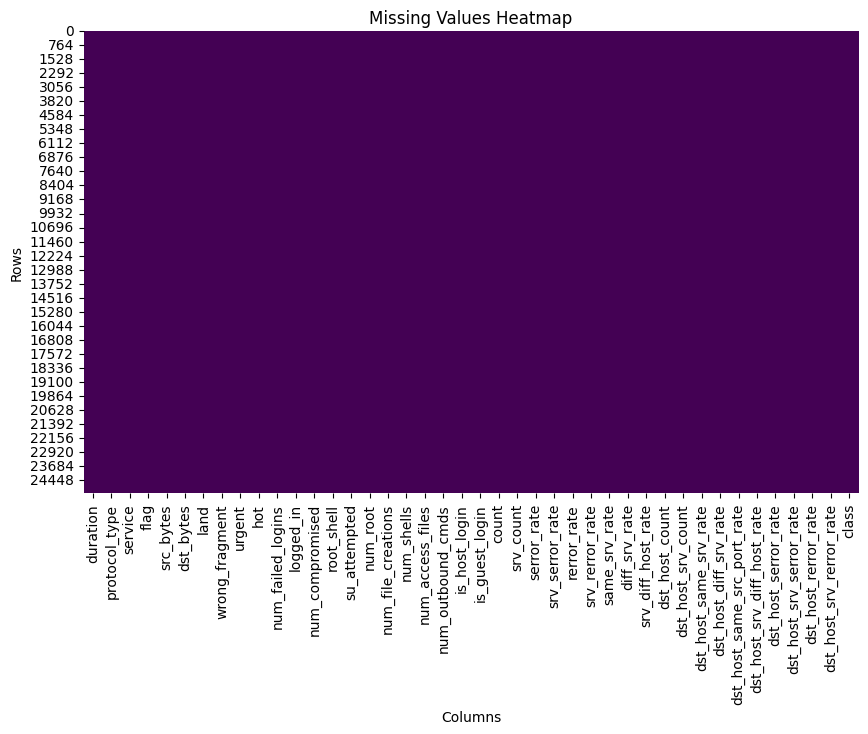

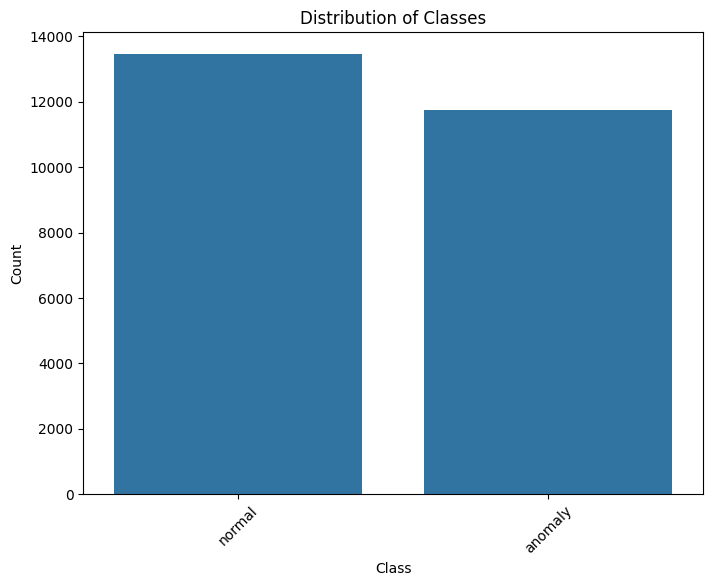

In [3]:

# VISUALIZATIONS FOR INITIAL INSPECTION

# 1. Missing Values Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# 2. Count Plot of the 'class' Column
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='class', order=df['class'].value_counts().index)
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


The heatmap visually represents the presence of missing values in the dataset.
The dark purple color indicates that there are no missing values in any of the columns. Since the entire heatmap is a solid dark color, it suggests that your dataset is complete, meaning there are no missing values across all rows and columns.

This Distribution of Classes bar chart shows the distribution of two classes: normal and anomaly.
The class normal has a slightly higher count than anomaly, indicating that the dataset is somewhat balanced but has slightly more normal observations.
Since the two categories have a relatively similar number of samples, the model may not be heavily biased toward one class, reducing the need for additional balancing techniques.

In [4]:
# Calculate the correlation matrix for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)


Correlation Matrix:
                             duration  src_bytes  dst_bytes      land  \
duration                     1.000000   0.084864   0.013258 -0.001012   
src_bytes                    0.084864   1.000000   0.003611 -0.000090   
dst_bytes                    0.013258   0.003611   1.000000 -0.000350   
land                        -0.001012  -0.000090  -0.000350  1.000000   
wrong_fragment              -0.010358  -0.000916  -0.003586 -0.000813   
urgent                      -0.000486  -0.000062   0.000345 -0.000056   
hot                          0.004202   0.000995   0.002539 -0.000819   
num_failed_logins            0.011108  -0.000260   0.005197 -0.000234   
logged_in                   -0.063703  -0.002040   0.012704 -0.007196   
num_compromised              0.095215  -0.000196   0.035852 -0.000195   
root_shell                   0.050547  -0.000383   0.020214 -0.000351   
su_attempted                 0.094243  -0.000267   0.035041 -0.000247   
num_root                     0.

Overall, the matrix reveals that while many features do not show strong linear relationships (correlations near 0), there are clusters of features—particularly those related to error rates and host metrics—that are highly interrelated. These insights can help guide feature selection, dimensionality reduction, and modeling strategies by highlighting both independent and redundant variables in the dataset.

Removing near-constant / zero-variance columns

There are columns that have almost the same value for most rows (zero or near‐zero variance). Such columns rarely help in clustering or association rules.

In [5]:
from sklearn.feature_selection import VarianceThreshold

# 2) Remove near-zero variance columns
# -----------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
vt = VarianceThreshold(threshold=0.01)  # Adjust the threshold as needed
vt.fit(df[numeric_cols])

low_variance_cols = [col for col, var in zip(numeric_cols, vt.variances_) if var < 0.01]
if low_variance_cols:
    print(f"Near-zero variance columns dropped: {low_variance_cols}")
    df.drop(columns=low_variance_cols, inplace=True)

# Re-compute numeric_cols after dropping columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

Near-zero variance columns dropped: ['land', 'urgent', 'num_failed_logins', 'root_shell', 'su_attempted', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login']


Let's separate and drop the class label (to mimic unsupervised learning). We will use it later for validation of results.

In [6]:
# 2.1 Separate the 'class' labels
true_labels = df['class'].copy()

# 2.2 Drop 'class' from features
df.drop('class', axis=1, inplace=True)


Now we encode and scale the values for preprocessing.

In [7]:
# 2.3 Encode categorical columns if they exist
categorical_cols = ['protocol_type', 'service', 'flag']  # Modify if needed
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# 2.4 Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

print("Shape of scaled data:", X_scaled.shape)


Shape of scaled data: (25192, 31)


Since we still have high number of dimension (31), it will be beneficial to apply dimension reduction. We are going to compute explained variancies for principal componentent number roughly equal to half of total number of dimensions.

In [8]:
# Set number of components for initial variance check
n_components_check = 15
pca_check = PCA(n_components=n_components_check, random_state=42)
pca_check.fit(X_scaled)

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca_check.explained_variance_ratio_)

# Print explained variance details
print(f"\nPCA -> Computed for {n_components_check} components.")
print("Explained variance (each component):", pca_check.explained_variance_ratio_)
print("Cumulative explained variance:", cumulative_variance)


PCA -> Computed for 15 components.
Explained variance (each component): [0.24872699 0.1671402  0.06821395 0.06552319 0.05497027 0.05170879
 0.03675177 0.03533186 0.0332394  0.03221558 0.03121899 0.02992816
 0.02510589 0.02255095 0.01980664]
Cumulative explained variance: [0.24872699 0.41586719 0.48408114 0.54960433 0.6045746  0.65628339
 0.69303516 0.72836702 0.76160643 0.79382201 0.825041   0.85496916
 0.88007505 0.902626   0.92243264]


We are going to proceed with 7 principal components since they explain pretty sufficient number of variance (0.69303516) and increasing their number further is not really beneficial since the increase in explained variance drops.


In [9]:
n_components_final = 7
pca = PCA(n_components=n_components_final, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Print final PCA details
print(f"\nPCA -> Reduced to {n_components_final} components.")
print("Final explained variance (each component):", pca.explained_variance_ratio_)
print("Final cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))
print("Shape of X_pca:", X_pca.shape, "\n")


PCA -> Reduced to 7 components.
Final explained variance (each component): [0.24872699 0.1671402  0.06821395 0.06552319 0.05497027 0.05170879
 0.03675177]
Final cumulative explained variance: [0.24872699 0.41586719 0.48408114 0.54960433 0.6045746  0.65628339
 0.69303516]
Shape of X_pca: (25192, 7) 



Now we are going to calculate Hopkins statistics to check for clusterability of scaled and PCA-reduced data.

In [10]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def hopkins_statistic(X, n_samples=100):
    """
    Computes the Hopkins statistic for a dataset X.

    Parameters:
      - X: numpy array of shape (n_samples, n_features)
      - n_samples: number of samples to use for the computation (default=100)

    Returns:
      - hopkins_value: A value between 0 and 1.
         Values close to 1 indicate high cluster tendency,
         around 0.5 suggest randomness (no natural clusters).
    """
    X = np.array(X)
    n = X.shape[0]

    # If n_samples is larger than the dataset, use the size of the dataset.
    if n_samples > n:
        n_samples = n

    # Randomly select n_samples points from X
    random_indices = np.random.choice(range(n), n_samples, replace=False)
    X_sample = X[random_indices]

    # Generate random points within the same bounds as X
    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)
    uniform_random_points = np.random.uniform(mins, maxs, (n_samples, X.shape[1]))

    # Fit NearestNeighbors on the original data
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)

    # For each sample point, the first neighbor is itself (distance=0),
    # so we take the second closest.
    distances_sample, _ = nbrs.kneighbors(X_sample)
    distances_random, _ = nbrs.kneighbors(uniform_random_points)

    # Sum the distances:
    # - u: distances from each sample point to its nearest neighbor (ignoring self)
    # - w: distances from each random point to its nearest neighbor in X
    u = np.sum(distances_sample[:, 1])
    w = np.sum(distances_random[:, 0])

    hopkins_value = w / (w + u)
    return hopkins_value

# Example: Compute Hopkins on both X_scaled and X_pca

# On the scaled data (before PCA)
hopkins_scaled = hopkins_statistic(X_scaled, n_samples=100)
print("Hopkins Statistic on Scaled Data:", hopkins_scaled)

# On the PCA-reduced data (which you'll use for clustering)
hopkins_pca = hopkins_statistic(X_pca, n_samples=100)
print("Hopkins Statistic on PCA Data:", hopkins_pca)


Hopkins Statistic on Scaled Data: 0.9981273514833493
Hopkins Statistic on PCA Data: 0.9983323928557325


Both of them are highly clusterable.


Checking the Elbow and Silhouette scores for K-means


k=2: Inertia=365413.63, Silhouette Score=0.475
k=3: Inertia=240321.37, Silhouette Score=0.580
k=4: Inertia=206207.95, Silhouette Score=0.567
k=5: Inertia=182635.37, Silhouette Score=0.580
k=6: Inertia=149320.19, Silhouette Score=0.625
k=7: Inertia=131241.14, Silhouette Score=0.636
k=8: Inertia=90365.90, Silhouette Score=0.638
k=9: Inertia=80831.22, Silhouette Score=0.634
k=10: Inertia=75453.11, Silhouette Score=0.639


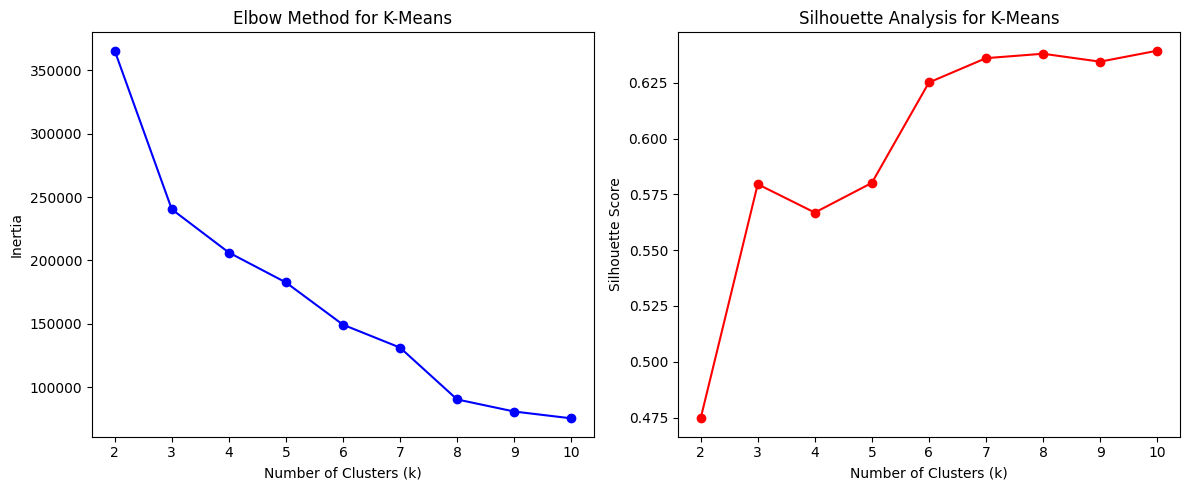

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Suppose we plan to cluster our PCA-reduced data (X_pca)
K_range = range(2, 11)  # Evaluate k from 2 to 10
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    inertias.append(kmeans.inertia_)
    # Silhouette score is only meaningful if there are at least 2 clusters
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={score:.3f}")

# Plot the Elbow (inertia vs k)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')

# Plot Silhouette Score vs k
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K-Means')

plt.tight_layout()
plt.show()


Inertia:

Inertia (the within-cluster sum of squares) decreases as we increase the number of clusters.
Notice that the largest drop in inertia occurs in the transition from lower values of k (e.g., k=2 to k=6). After k=7, the decrease is less dramatic, which suggests that the "elbow" of the curve is around 7 clusters.


Silhouette Score:

The silhouette score measures how similar an object is to its own cluster compared to other clusters, with higher values indicating better-defined clusters.
The score increases significantly up to k=7, then it flattens out (k=7: 0.636, k=8: 0.638, k=9: 0.634, k=10: 0.639).
Even though k=10 gives the highest silhouette score (0.639), the improvement beyond k=7 is marginal. This means we are not gaining much in cluster separation by increasing the number of clusters beyond 7.

Basing on the above, let's choose k=7



Cluster Distribution:
0    11077
1     6953
3     2831
4     1883
2     1355
5      928
6      165
Name: count, dtype: int64
Overall Silhouette Score for k=7: 0.636


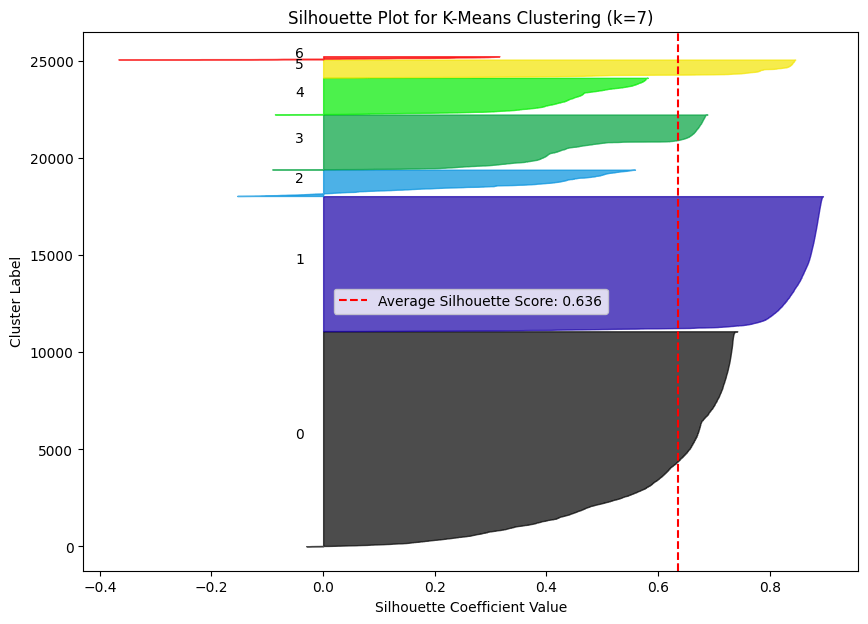

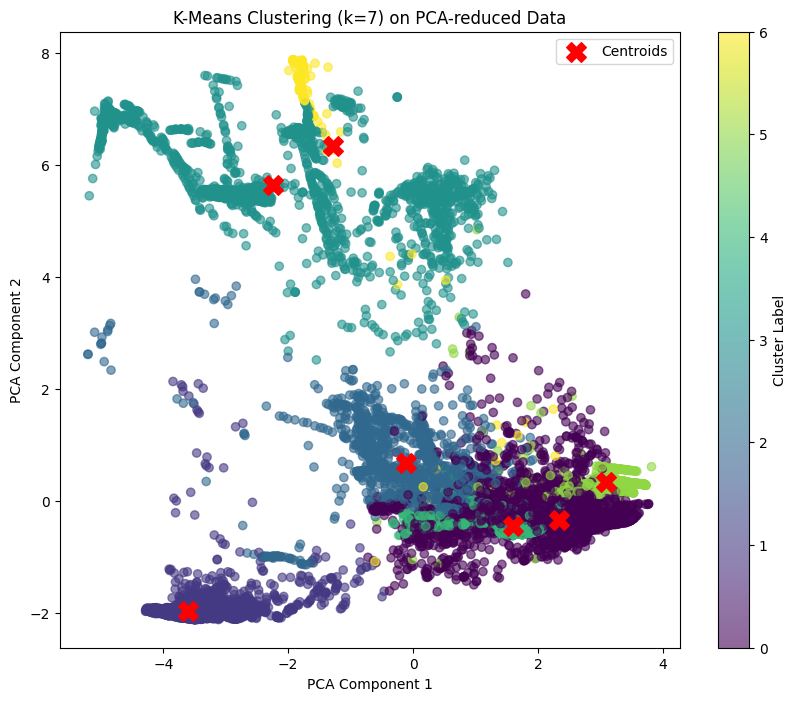

Crosstab of True Labels vs. Cluster Labels:
Cluster Label      0     1    2     3     4    5    6
True Label                                           
anomaly          529  6928  534  2273   495  845  139
normal         10548    25  821   558  1388   83   26
Adjusted Rand Index: 0.477


In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# ------------------------------
# 1. Run K-Means with k = 7
# ------------------------------
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)  # Use PCA-reduced data

# Print the distribution of samples across clusters
print("Cluster Distribution:")
print(pd.Series(cluster_labels).value_counts())

# Compute and print the overall silhouette score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"Overall Silhouette Score for k={k}: {silhouette_avg:.3f}")

# ------------------------------
# 2. Detailed Silhouette Plot
# ------------------------------
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

plt.figure(figsize=(10, 7))
y_lower = 10  # starting y position for the first cluster plot
for i in range(k):
    # Aggregate silhouette scores for samples in cluster i, then sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers in the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Update y_lower for next plot (with spacing)
    y_lower = y_upper + 10

plt.xlabel("Silhouette Coefficient Value")
plt.ylabel("Cluster Label")
plt.title("Silhouette Plot for K-Means Clustering (k=7)")
plt.axvline(x=silhouette_avg, color="red", linestyle="--",
            label=f"Average Silhouette Score: {silhouette_avg:.3f}")
plt.legend()
plt.show()

# ------------------------------
# 3. Scatter Plot of Clusters
# ------------------------------
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=cluster_labels, cmap='viridis', alpha=0.6)
# Overlay the cluster centers (in PCA space)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label="Centroids")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering (k=7) on PCA-reduced Data")
plt.colorbar(scatter, label="Cluster Label")
plt.legend()
plt.show()

# ------------------------------
# 4. Crosstab with True Labels
# ------------------------------
# If we have true labels stored in a variable 'true_labels'
# we can generate a crosstab to compare true classes with the clusters.
if 'true_labels' in globals():
    # Ensure that the true_labels array matches the order of the data used for clustering.
    df_crosstab = pd.crosstab(true_labels, cluster_labels,
                              rownames=['True Label'], colnames=['Cluster Label'])
    print("Crosstab of True Labels vs. Cluster Labels:")
    print(df_crosstab)

from sklearn.metrics import adjusted_rand_score

# Assuming cluster_labels are from  K-Means and true_labels are our ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index: {ari:.3f}")



**Silhouette plot**

The red dashed vertical line on Silhouette plot represents the average silhouette score, which is 0.636. Each colored band represents a different cluster, showing the distribution of silhouette scores for its members. The thickness of each band represents the number of data points in that cluster. A cluster with wider distribution suggests variability in cluster cohesion.

Some clusters have high silhouette coefficients (close to 1), indicating well-separated groups. One cluster (the red one at the top) has a negative silhouette coefficient, meaning some points are likely misclassified. Clusters should ideally have similar widths to indicate balanced clustering.

The average silhouette score of 0.636 suggests moderate to good clustering performance.

**Visualisation of PCA-reduced data and K-means clustering**

The data has been reduced to two principal components using Principal Component Analysis (PCA) for ease of visualisation. Each point represents a data sample, colored according to its assigned cluster label.

The 7 clusters are visible with different colors. The red X markers represent the centroids of each cluster, which are the mean points around which K-Means groups data. Some centroids are close to dense areas, indicating well-defined clusters, while others seem less aligned with tightly packed points,

Some clusters (e.g., the dark blue and purple ones) appear compact and well-formed.
Other clusters (e.g., light green and yellow) seem more dispersed or overlapping, suggesting some ambiguity in clustering.

Some points from different clusters are closely spaced, possibly leading to misclassification. Some clusters are much denser and compact, while others are sparse and scattered. This might indicate that K=7 is not the best choice, or that data is not evenly distributed. A few points seem isolated from clusters, suggesting possible outliers

**Cluster Purity (based on Crosstab and Adjusted Rand index):**

**High Purity Clusters:**

Cluster 1: Almost entirely anomalies (6,928 vs. 25)

Cluster 5: Largely anomalies (845 vs. 83)

Cluster 6: Mostly anomalies (139 vs. 26)


**Normal-Dominated Clusters:**

Cluster 0: Primarily normal (10,548 vs. 529)

Cluster 4: Also skewed towards normal (1,388 vs. 495)


**Mixed Cluster:**

Cluster 2: Contains a mix but leans towards normal.

Cluster 3: Although it has a significant number of anomalies (2,273), it also has a fair share of normals (558).

**Separation Quality:**

Some clusters clearly separate the anomalies from the normals. For example, cluster 1 is almost exclusively anomalies, which suggests that the K-Means algorithm (with k=7) is able to isolate a set of data points that are very different from the normal behavior.

**Potential for Further Refinement:**

The mixed clusters (like cluster 2) might need further investigation. We might explore whether additional features or a different clustering algorithm could further separate these groups.

The above is also supported by Adjusted Rand Index: 0.477 which shows medium quiality of separation.


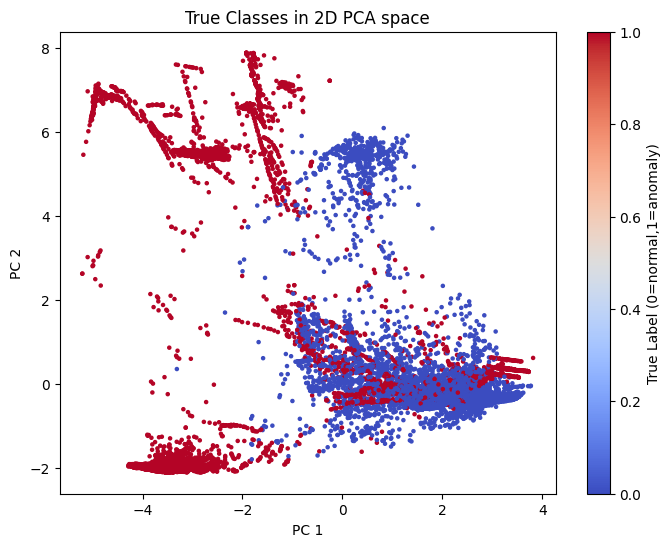

In [13]:
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Color by 'true_labels' (normal=0, anomaly=1)
label_map = {'normal':0, 'anomaly':1}
numeric_labels = true_labels.map(label_map)

plt.figure(figsize=(8,6))
scatter_gt = plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=numeric_labels, cmap="coolwarm", s=5)
plt.colorbar(scatter_gt, label="True Label (0=normal,1=anomaly)")
plt.title("True Classes in 2D PCA space")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()


**True classes plot **

Points are colored based on their true labels: red (normal) and blue (anomaly). Red (normal) points are more spread out, possibly indicating normal variability within anomaly class.

The K-Means clustering with k=7 does not directly align with the binary classification (normal vs. anomaly). Some clusters in the K-Means plot seem to contain both red and blue points from the true labels plot, indicating mixed classification. Notably, the yellow and light green clusters overlap with both classes, suggesting these clusters may not be well-separated in terms of anomaly detection.

In the true label plot, the blue anomaly region is relatively well-separated from the red normal points, suggesting a clear anomaly pattern.
K-Means clusters corresponding to these regions (e.g., the blue and purple clusters) seem compact but don't fully capture the anomaly separation.

In the true labels plot, red points are more scattered, indicating normal variations. However, K-Means clusters do not seem to capture this variability effectively.
K-Means might be overfitting or underfitting due to the choice of k=7.

K-Means clustering with k=7 does not align perfectly with the binary classification of normal vs. anomaly. Some clusters mix both classes, indicating possible misclassification or insufficient separation.

Now we are going to proceed with DBSCAN first checking for suitable epsilon value.

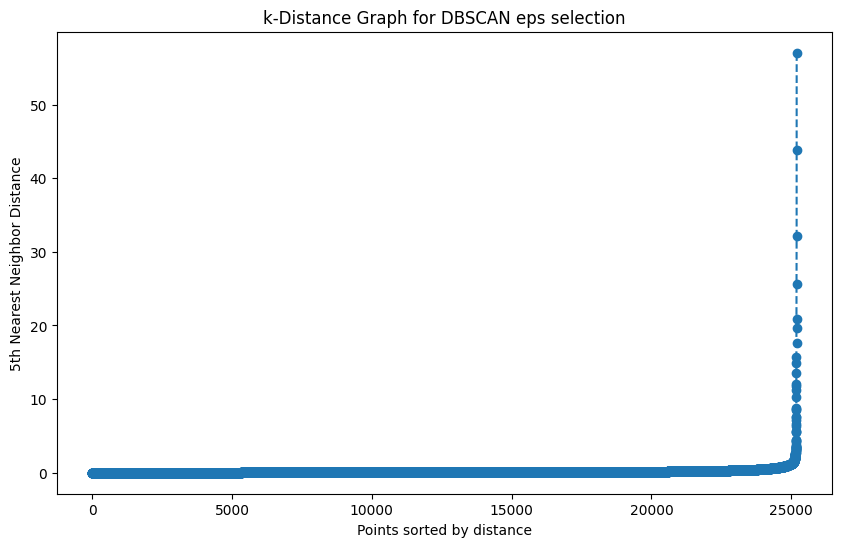

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Choose min_samples (let's use 5, but it can be tuned)
min_samples = 5

# Fit NearestNeighbors on the PCA data
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# For each point, consider the distance to its kth (min_samples-th) neighbor
kth_distances = np.sort(distances[:, -1])  # last column is the kth neighbor

plt.figure(figsize=(10, 6))
plt.plot(kth_distances, marker='o', linestyle='--')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}th Nearest Neighbor Distance')
plt.title('k-Distance Graph for DBSCAN eps selection')
plt.show()


Based on k-Distance Graph optimal epsilon (eps) for DBSCAN should be chosen at the "elbow" point, where the distance values start increasing rapidly; we could assume values of eps in range [2,3]. Let's proceed with mid value of 2.5



DBSCAN Cluster Distribution (including noise labeled as -1):
 0    25093
 1       54
-1       40
 2        5
Name: count, dtype: int64
Silhouette Score (excluding noise): 0.335
Adjusted Rand Index (excluding noise): 0.001


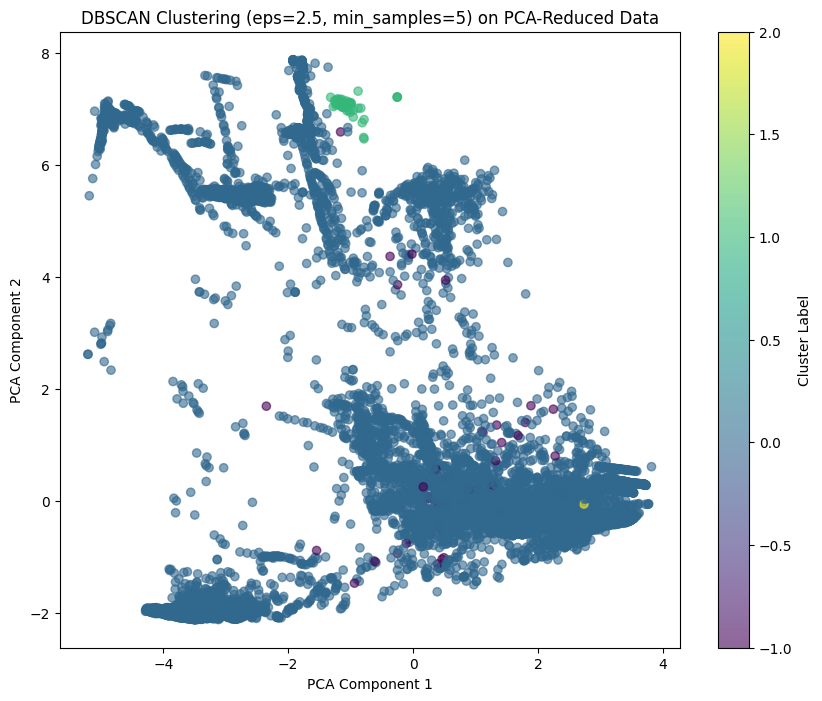

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

# ------------------------------
# 1. Run DBSCAN with eps=2.5, min_samples=5
# ------------------------------
dbscan = DBSCAN(eps=2.5, min_samples=5)
labels_db = dbscan.fit_predict(X_pca)

# ------------------------------
# 2. Check Cluster Distribution
# ------------------------------
print("DBSCAN Cluster Distribution (including noise labeled as -1):")
print(pd.Series(labels_db).value_counts())

# ------------------------------
# 3. Evaluate Silhouette Score
# ------------------------------
# Note: Silhouette score is only defined if there are at least 2 clusters.
# If noise exists (label -1), we compute the score on non-noise points.
unique_labels = set(labels_db)
if len(unique_labels) > 1:
    if -1 in unique_labels:
        mask = labels_db != -1
        if len(set(labels_db[mask])) > 1:  # ensure at least two clusters in non-noise
            sil_score = silhouette_score(X_pca[mask], labels_db[mask])
            print(f"Silhouette Score (excluding noise): {sil_score:.3f}")
        else:
            print("Not enough clusters (excluding noise) to compute Silhouette Score.")
    else:
        sil_score = silhouette_score(X_pca, labels_db)
        print(f"Silhouette Score: {sil_score:.3f}")
else:
    print("DBSCAN did not find more than one cluster; cannot compute Silhouette Score.")

# ------------------------------
# 4. Evaluate Adjusted Rand Index (ARI)
# ------------------------------
# This step is only applicable if we have true labels available.
if 'true_labels' in globals():
    # If noise is present, we might want to compute ARI only on the non-noise points.
    if -1 in unique_labels:
        mask = labels_db != -1
        if len(true_labels[mask]) > 0 and len(set(labels_db[mask])) > 1:
            ari = adjusted_rand_score(true_labels[mask], labels_db[mask])
            print(f"Adjusted Rand Index (excluding noise): {ari:.3f}")
        else:
            print("Not enough clusters (excluding noise) to compute ARI.")
    else:
        ari = adjusted_rand_score(true_labels, labels_db)
        print(f"Adjusted Rand Index: {ari:.3f}")
else:
    print("True labels not available. Skipping ARI calculation.")

# ------------------------------
# 5. Visualize the Clustering Result in PCA Space
# ------------------------------
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=labels_db, cmap='viridis', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering (eps=2.5, min_samples=5) on PCA-Reduced Data")
plt.colorbar(scatter, label="Cluster Label")
plt.show()


Cluster Distribution

Cluster 0: 25,093 points

Cluster 1: 54 points

Cluster 2: 5 points

Noise (-1): 40 points

Interpretation:

Dominant Cluster:
The vast majority of our data (25,093 points) falls into cluster 0. This suggests that most of the data points are very similar in terms of the density-based criteria used by DBSCAN.

Small Clusters:
Clusters 1 and 2 are very small (54 and 5 points, respectively). These may represent either small, distinct sub-groups or potentially outlier groups that are just dense enough to form their own clusters.
Noise Points:
There are 40 points labeled as noise (with the label -1). These are data points that did not meet the density requirements to be assigned to any cluster.

A Silhouette score of 0.335 is relatively low. This suggests that, on average, the separation between the clusters isn’t very strong. In this case, the dominant cluster (cluster 0) likely drives most of the data structure, while the few small clusters might not be very well separated from the rest of the data.

ARI measures the similarity between your clustering and the ground truth labels, where 1 is perfect agreement, 0 is chance-level, and negative values indicate worse than random.

An ARI of 0.001 is extremely low—essentially close to 0. This means that the clusters identified by DBSCAN have almost no agreement with the true labels.

This can happen for several reasons:

The true underlying structure in the data might not be well captured by density-based clustering with these parameters.

The ground truth labels are be based on a different notion of "class" (for example, they represent anomalies vs. normal behavior) that doesn’t align with the density differences DBSCAN is detecting.

The parameters for DBSCAN (eps = 2.5, min_samples = 5) may not be optimal for capturing the intrinsic structure that corresponds to the true labels.





In next step we will apply HDBSCAN, but before let's check which cluster sizes and sample values are good.

In [14]:
import warnings
import hdbscan
import pandas as pd

# Suppress FutureWarnings from sklearn
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define ranges for parameters
min_cluster_sizes = [5, 10, 15, 20]
min_samples_values = [None, 5, 10]

results = []  # To store results for each parameter combination

for mcs in min_cluster_sizes:
    for ms in min_samples_values:
        # Create and fit the HDBSCAN model
        clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        cluster_labels = clusterer.fit_predict(X_pca)

        # Count the number of clusters found (ignore noise label -1)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

        print(f"min_cluster_size={mcs}, min_samples={ms}, clusters found: {n_clusters}")
        results.append((mcs, ms, n_clusters))

# Convert results to a DataFrame
df_results = pd.DataFrame(results, columns=['min_cluster_size', 'min_samples', 'n_clusters'])
print(df_results)


min_cluster_size=5, min_samples=None, clusters found: 536
min_cluster_size=5, min_samples=5, clusters found: 536
min_cluster_size=5, min_samples=10, clusters found: 272
min_cluster_size=10, min_samples=None, clusters found: 203
min_cluster_size=10, min_samples=5, clusters found: 296
min_cluster_size=10, min_samples=10, clusters found: 203
min_cluster_size=15, min_samples=None, clusters found: 127
min_cluster_size=15, min_samples=5, clusters found: 191
min_cluster_size=15, min_samples=10, clusters found: 158
min_cluster_size=20, min_samples=None, clusters found: 93
min_cluster_size=20, min_samples=5, clusters found: 144
min_cluster_size=20, min_samples=10, clusters found: 120
    min_cluster_size  min_samples  n_clusters
0                  5          NaN         536
1                  5          5.0         536
2                  5         10.0         272
3                 10          NaN         203
4                 10          5.0         296
5                 10         10.0       

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN Cluster Distribution (including noise labeled as -1):
-1      7564
 84     5787
 121    1621
 10     1397
 82      544
        ... 
 58       15
 128      15
 6        15
 2        15
 62       15
Name: count, Length: 159, dtype: int64
Silhouette Score (excluding noise): 0.241
Adjusted Rand Index (excluding noise): 0.247


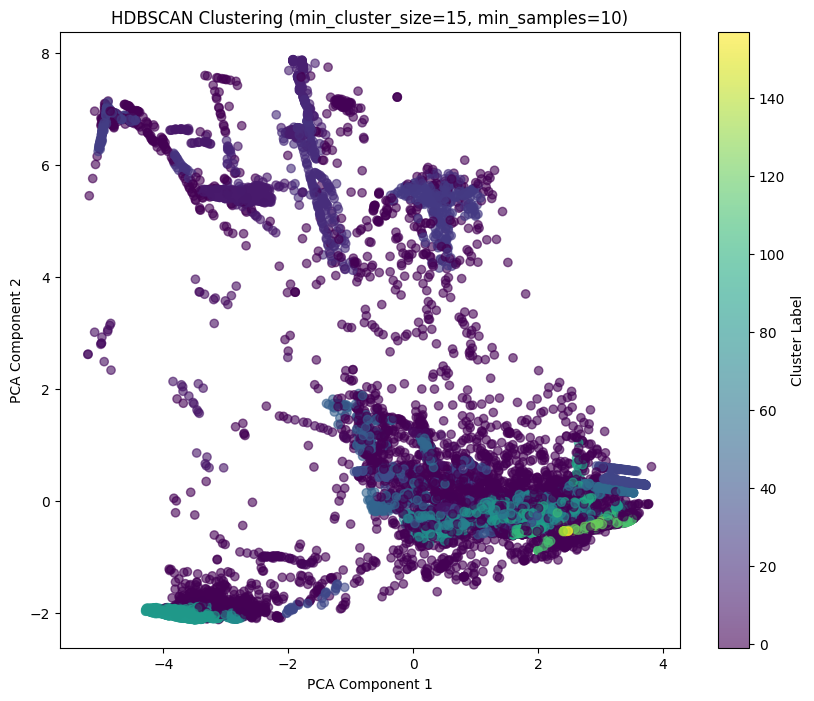

In [ ]:
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Set the HDBSCAN parameters based on your sweep
min_cluster_size = 15
min_samples = 10

# Create and fit the HDBSCAN model
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
cluster_labels = clusterer.fit_predict(X_pca)

# ------------------------------
# 1. Cluster Distribution
# ------------------------------
print("HDBSCAN Cluster Distribution (including noise labeled as -1):")
cluster_distribution = pd.Series(cluster_labels).value_counts()
print(cluster_distribution)

# ------------------------------
# 2. Silhouette Score (excluding noise)
# ------------------------------
unique_labels = set(cluster_labels)
if len(unique_labels) > 1:
    if -1 in unique_labels:
        mask = cluster_labels != -1  # select non-noise points
        # Ensure that there are at least 2 clusters among the non-noise points
        if len(set(cluster_labels[mask])) > 1 and np.sum(mask) > 1:
            sil = silhouette_score(X_pca[mask], cluster_labels[mask])
            print(f"Silhouette Score (excluding noise): {sil:.3f}")
        else:
            print("Not enough clusters (excluding noise) to compute the Silhouette Score.")
    else:
        sil = silhouette_score(X_pca, cluster_labels)
        print(f"Silhouette Score: {sil:.3f}")
else:
    print("HDBSCAN did not find more than one cluster; cannot compute Silhouette Score.")

# ------------------------------
# 3. Adjusted Rand Index (ARI)
# ------------------------------
# This step compares the clustering labels with the true labels (if available).
if 'true_labels' in globals():
    if -1 in unique_labels:
        mask = cluster_labels != -1
        if len(set(cluster_labels[mask])) > 1 and len(true_labels[mask]) > 0:
            ari = adjusted_rand_score(true_labels[mask], cluster_labels[mask])
            print(f"Adjusted Rand Index (excluding noise): {ari:.3f}")
        else:
            print("Not enough clusters (excluding noise) to compute ARI.")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        print(f"Adjusted Rand Index: {ari:.3f}")
else:
    print("True labels not available; skipping ARI calculation.")

# ------------------------------
# 4. Visualization of Clustering in PCA Space
# ------------------------------
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"HDBSCAN Clustering (min_cluster_size={min_cluster_size}, min_samples={min_samples})")
plt.colorbar(scatter, label="Cluster Label")
plt.show()


HDBSCAN has detected a very high number of clusters (159 total labels) with a large noise cluster, indicating a very fragmented clustering structure.

Silhouette Score (0.241) suggests that the clusters are not very well separated.Clusters might be overlapping, or the boundary between clusters is not very distinct. This low value can also be a side effect of having many small clusters that might be less stable.

An ARI of 0.247 indicates a weak correlation between the clusters found by HDBSCAN and the true labels. This low ARI suggests that the density-based clusters detected do not align strongly with the ground truth classes.



We can check PCA to ensure that the feature space is optimal for capturing the clusters.

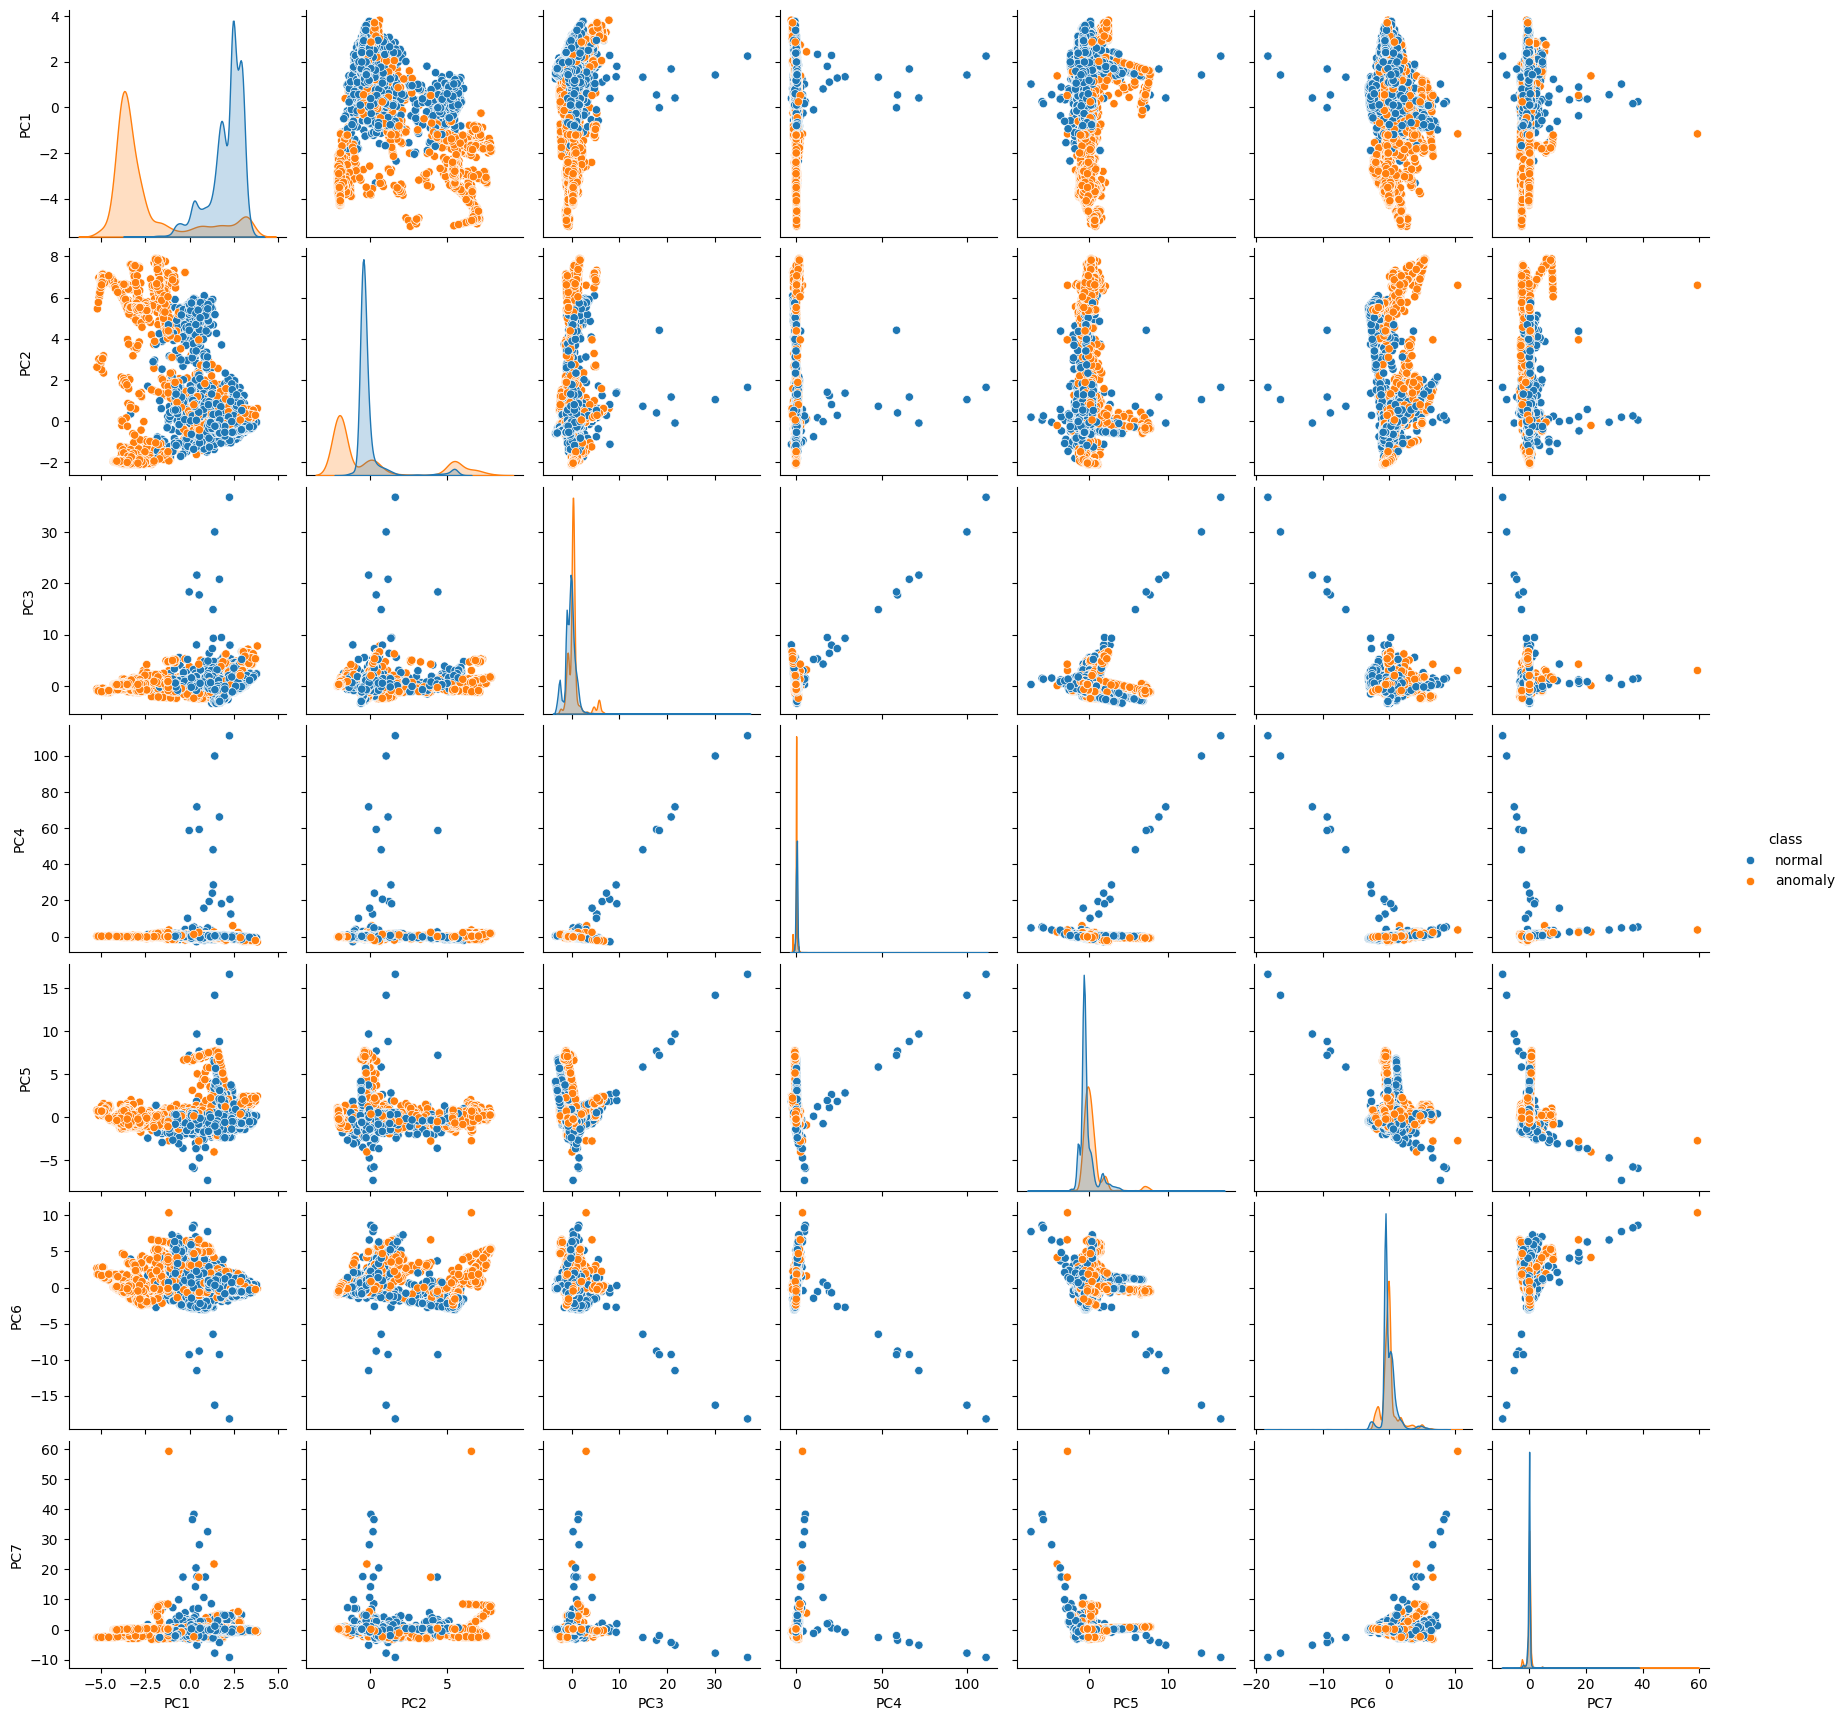

In [ ]:
import seaborn as sns
pca_df = pd.DataFrame(X_pca[:, :7], columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])
pca_df['class'] = true_labels.values

sns.pairplot(pca_df, hue='class', diag_kind='kde')
plt.show()


Each off‐diagonal subplot shows how two PCs distribute relative to one another for both classes, and the diagonal KDEs show how each class is spread out along that single dimension.

PC1 already appears to separate “normal” from “anomaly” quite strongly (the orange and blue density peaks are well apart). PC2 is also doing quite good job

PC3, PC4, PC5, PC6 and PC7  show overlapping clouds for the two classes, but there are regions (for example, large values in PC3 or PC4) where only one class predominates.

Overall, the pairplot suggests that the first principal components capture much of the separation between normal and anomalous observations, and that, to a lesser extent, the higher components also help distinguish them. However, the separation is mixed for higher components and doubtfully is really beneficial.

Basically, we observe the proof of not-feasibility of PCA for high-dimensional datasets. Possible approach for future tuning: application of PCA to reduce to a smaller number of features to lessen the load on MDS and application of MDS afterwards. Direct application of MDS on dataset of that size is very computationally intensive and seems not rational; possibly, we can also apply MDS on sampled data, however, without proper domain knowledge related to variables of the dataset it is quite hard to predict sample size selection which will capture its characteristics sufficiently.









In [ ]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import gc

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load the dataset
df = pd.read_csv("/content/gdrive/My Drive/Train_data_Intrusion1.csv", sep=';')

# Select a subset of columns (you can further reduce columns if needed)
cols_to_use = [
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'logged_in',
    'count',
    'srv_count',
    'serror_rate',
    'rerror_rate',
    'class'
]
df = df[cols_to_use]

# Discretize numeric columns into 3 bins, dropping duplicate edges.
for col in ['src_bytes', 'dst_bytes', 'count', 'srv_count']:
    try:
        df[col] = pd.qcut(
            df[col],
            3,
            labels=[f"low_{col}", f"medium_{col}", f"high_{col}"],
            duplicates='drop'
        )
    except Exception as e:
        df[col] = df[col].astype(str)

# Use an even smaller sample to reduce memory usage (e.g., 0.5% sample)
df_small = df.sample(frac=0.005, random_state=42)

# Create a working copy for association analysis.
df_assoc = df_small.copy()

# Convert all columns to string (if not already) and perform one-hot encoding directly to sparse format.
df_assoc = df_assoc.astype(str)
df_onehot = pd.get_dummies(df_assoc, sparse=True)
df_onehot_bool = df_onehot.astype(bool)

print("\nShape of one-hot encoded data:", df_onehot_bool.shape)

# Mine frequent itemsets using the apriori algorithm.
# Note: With a smaller sample, adjust the min_support threshold as needed.
frequent_itemsets = apriori(df_onehot_bool, min_support=0.01, use_colnames=True)
# Sort Frequent Itemsets
frequent_itemsets_sorted = frequent_itemsets.sort_values(by="support", ascending=False)
print("\nFrequent Itemsets (sorted by support, first 10 rows):")
print(frequent_itemsets_sorted.head(10))

# Generate association rules.
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort All Association Rules
rules_sortedlift = rules.sort_values(by="lift", ascending=False)
print("\nAssociation Rules (sorted by lift, first 10 rows):")
print(rules_sortedlift.head(10))

rules_sortedconf = rules.sort_values(by="confidence", ascending=False)
print("\nAssociation Rules (sorted by confidence, first 10 rows):")
print(rules_sortedconf.head(10))

rules_sortedsupp = rules.sort_values(by="support", ascending=False)
print("\nAssociation Rules (sorted by support, first 10 rows):")
print(rules_sortedsupp.head(10))

# **Filter for rules where the consequent leads to an anomaly (assuming anomaly is encoded as 'class_anomaly').**
anomaly_rules = rules[rules['consequents'].apply(lambda x: 'class_anomaly' in x)]

# Sort Anomaly Rules
anomaly_rules_sortedlift = anomaly_rules.sort_values(by="lift", ascending=False)
print("\nAnomaly Rules (sorted by lift, first 10 rows):")
print(anomaly_rules_sortedlift.head(10))

anomaly_rules_sortedconf = anomaly_rules.sort_values(by="confidence", ascending=False)
print("\nAnomaly Rules (sorted by confidence, first 10 rows):")
print(anomaly_rules_sortedconf.head(10))

anomaly_rules_sortedsupp = anomaly_rules.sort_values(by="support", ascending=False)
print("\nAnomaly Rules (sorted by support, first 10 rows):")
print(anomaly_rules_sortedsupp.head(10))

# Clean up memory if needed.
del df, df_small, df_assoc, df_onehot
gc.collect()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/gdrive

Shape of one-hot encoded data: (126, 167)

Frequent Itemsets (sorted by support, first 10 rows):
      support                              itemsets
49   0.857143                     (rerror_rate_0.0)
1    0.817460                   (protocol_type_tcp)
101  0.674603  (protocol_type_tcp, rerror_rate_0.0)
47   0.642857                     (serror_rate_0.0)
39   0.634921                         (logged_in_0)
33   0.579365                         (dst_bytes_0)
397  0.555556            (dst_bytes_0, logged_in_0)
21   0.547619                             (flag_SF)
324  0.547619            (flag_SF, rerror_rate_0.0)
499  0.531746    (serror_rate_0.0, rerror_rate_0.0)

Association Rules (sorted by lift, first 10 rows):
                                               antecedents  \
1383370  (rerror_rate_1.0, srv_count_medium_srv_count, ...   
784864    (count_low_count, serror_rate_1.0, class_normal)   
1782134  (flag_SF, class_normal, service_private, serro...   
178

43

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


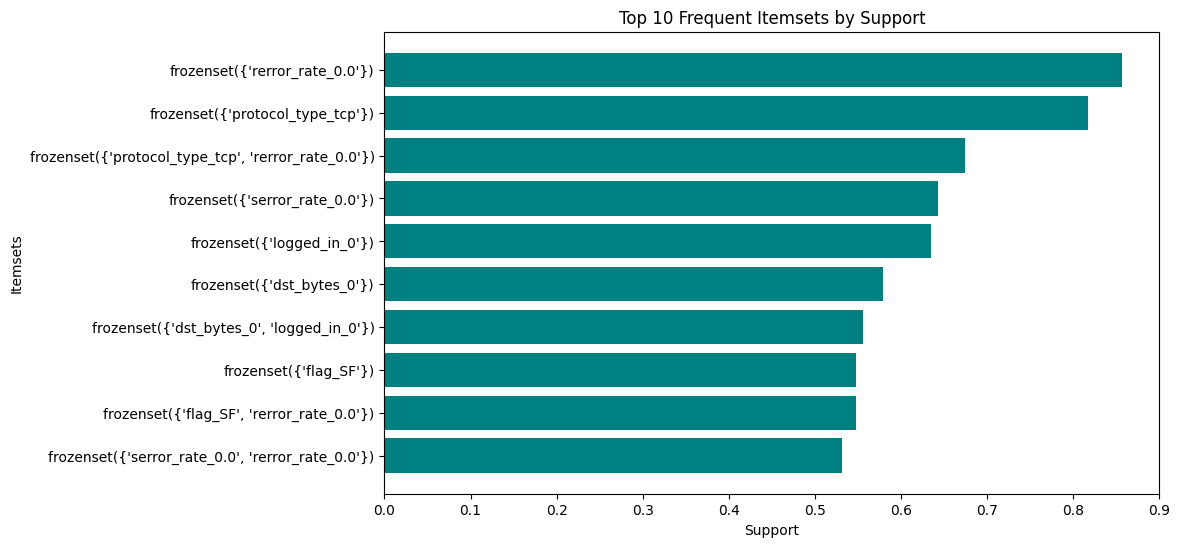

In [ ]:
import matplotlib.pyplot as plt

# Take top 10 frequent itemsets
top_frequent_itemsets = frequent_itemsets_sorted.head(10)

plt.figure(figsize=(10, 6))
plt.barh(
    top_frequent_itemsets["itemsets"].astype(str),
    top_frequent_itemsets["support"],
    color="teal"
)
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.title("Top 10 Frequent Itemsets by Support")
plt.gca().invert_yaxis()  # Flip the order to have the highest at the top
plt.show()



The itemsets are ranked by how often they occur in the dataset (support).
For example, items like (rerror_rate_0.0), (protocol_type_tcp), and their combinations have high support (e.g., ~0.85, ~0.82), indicating they appear in a large fraction of the transactions.

As we have particular interest in obtaining rules which are related to anomalies, let's proceed with visualisation and interpreatation.





/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


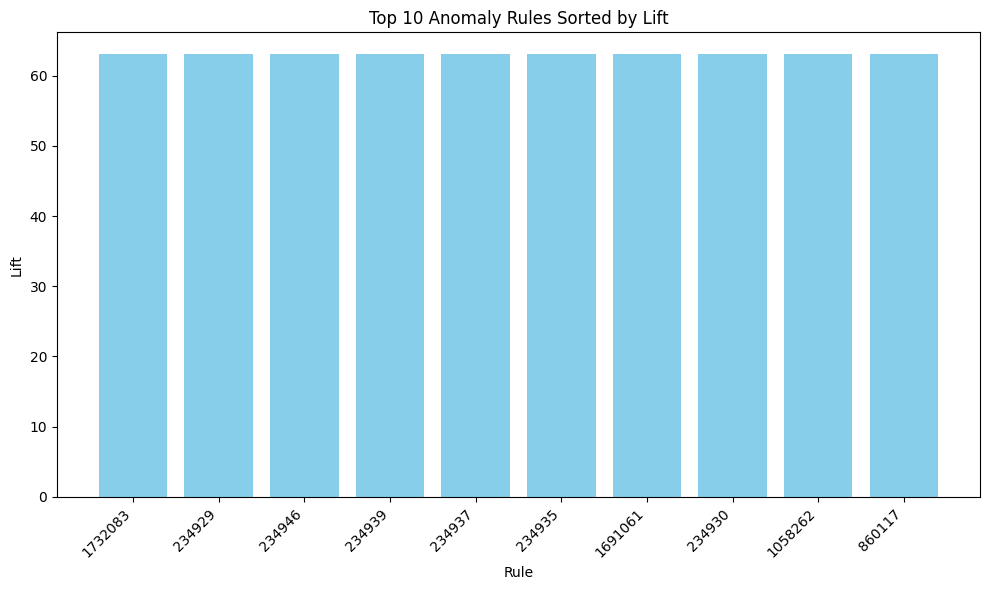

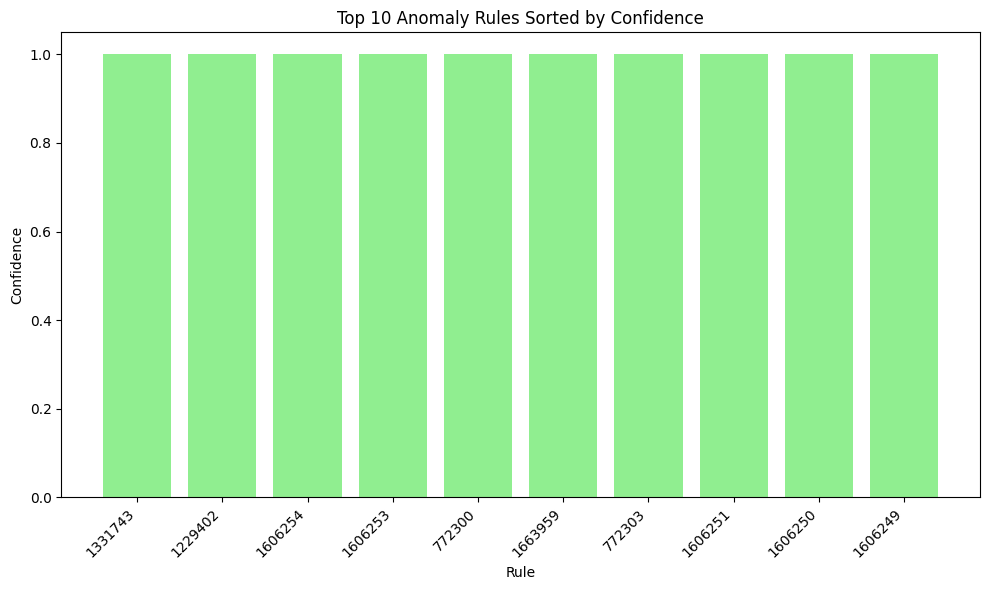

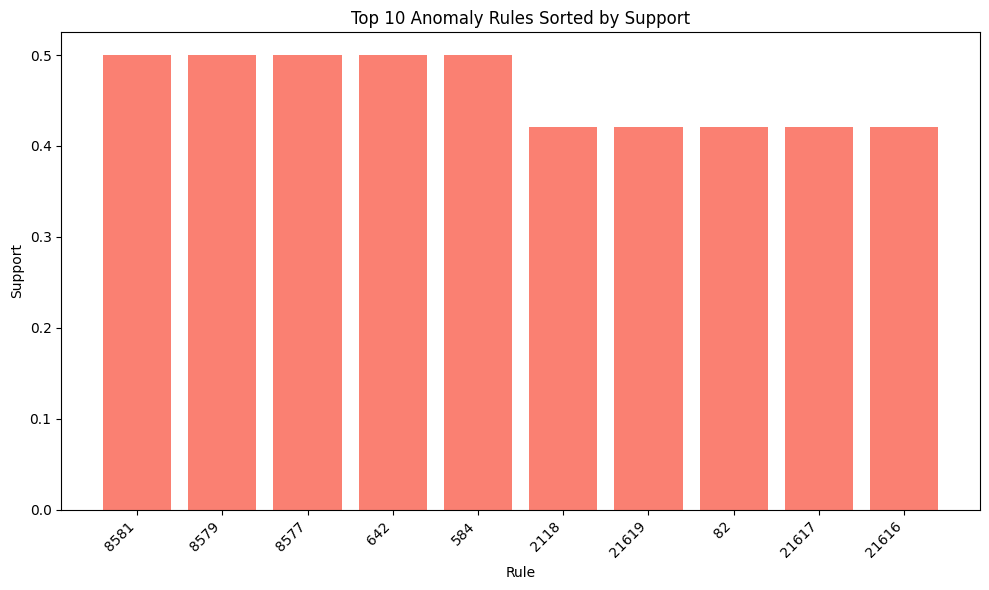

In [ ]:
import matplotlib.pyplot as plt

# Sort the anomaly rules and select the top 10 for each metric
anomaly_rules_sortedlift = anomaly_rules.sort_values(by="lift", ascending=False).head(10)
anomaly_rules_sortedconf = anomaly_rules.sort_values(by="confidence", ascending=False).head(10)
anomaly_rules_sortedsupp = anomaly_rules.sort_values(by="support", ascending=False).head(10)

# Optional: Create a label for each rule by combining antecedents and consequents.
# Uncomment and adjust the function if your DataFrame has 'antecedents' and 'consequents' columns.
def create_rule_label(row):
    # Convert sets/frozensets to strings if needed
    antecedents = ', '.join(list(row['antecedents'])) if isinstance(row['antecedents'], (list, set, frozenset)) else str(row['antecedents'])
    consequents = ', '.join(list(row['consequents'])) if isinstance(row['consequents'], (list, set, frozenset)) else str(row['consequents'])
    return f"{antecedents} -> {consequents}"

# Uncomment the following lines if your DataFrame includes 'antecedents' and 'consequents'
# anomaly_rules_sortedlift['rule'] = anomaly_rules_sortedlift.apply(create_rule_label, axis=1)
# anomaly_rules_sortedconf['rule'] = anomaly_rules_sortedconf.apply(create_rule_label, axis=1)
# anomaly_rules_sortedsupp['rule'] = anomaly_rules_sortedsupp.apply(create_rule_label, axis=1)

# ---------------------- #
# Visualization by Lift  #
# ---------------------- #
plt.figure(figsize=(10, 6))
plt.bar(range(len(anomaly_rules_sortedlift)), anomaly_rules_sortedlift['lift'], color='skyblue')
# Use custom rule labels if available, otherwise use index labels.
# labels = anomaly_rules_sortedlift['rule']
labels = anomaly_rules_sortedlift.index.astype(str)
plt.xticks(range(len(anomaly_rules_sortedlift)), labels, rotation=45, ha="right")
plt.xlabel('Rule')
plt.ylabel('Lift')
plt.title('Top 10 Anomaly Rules Sorted by Lift')
plt.tight_layout()
plt.show()

# --------------------------- #
# Visualization by Confidence #
# --------------------------- #
plt.figure(figsize=(10, 6))
plt.bar(range(len(anomaly_rules_sortedconf)), anomaly_rules_sortedconf['confidence'], color='lightgreen')
# labels = anomaly_rules_sortedconf['rule']
labels = anomaly_rules_sortedconf.index.astype(str)
plt.xticks(range(len(anomaly_rules_sortedconf)), labels, rotation=45, ha="right")
plt.xlabel('Rule')
plt.ylabel('Confidence')
plt.title('Top 10 Anomaly Rules Sorted by Confidence')
plt.tight_layout()
plt.show()

# ------------------------- #
# Visualization by Support  #
# ------------------------- #
plt.figure(figsize=(10, 6))
plt.bar(range(len(anomaly_rules_sortedsupp)), anomaly_rules_sortedsupp['support'], color='salmon')
# labels = anomaly_rules_sortedsupp['rule']
labels = anomaly_rules_sortedsupp.index.astype(str)
plt.xticks(range(len(anomaly_rules_sortedsupp)), labels, rotation=45, ha="right")
plt.xlabel('Rule')
plt.ylabel('Support')
plt.title('Top 10 Anomaly Rules Sorted by Support')
plt.tight_layout()
plt.show()


**Sorted by Lift**

The top anomaly rules show a lift of 63.0, with low support (0.01587) and 100% confidence. Very high lift ndicates a very strong association between rare features in the anomalies. These rules involve events that seldom occur, so while the association is striking, it is based on a small subset of the data. Every time the antecedent appears, the consequent always appears, making the association very reliable—at least within these few occurrences.

**Sorted by Confidence**

All rules have 100% confidence, but their lift values vary widely (from ~2.5 up to 21 or more). The consequents are always observed when the antecedents appear.The strength of the association relative to random chance varies. A higher lift (e.g., 21) suggests a much stronger anomaly association, while lower values indicate more common patterns even among anomalies.

**Sorted by Support**

The most frequent anomaly rules show support around 0.5, with confidence values in the 0.79–0.90 range and lift values around 1.5–1.8. These rules capture the more common anomalous patterns. Although these patterns are frequent and mostly reliable, the strength of their association is modest, suggesting that while they are typical in anomalies, they are not dramatically different from what might be expected by chance.


Now, let's check which antecedents are linked with each other increasing the probability of leading to anomaly.

In [ ]:
import random
from itertools import combinations
import time
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Start timer
start_time = time.time()

# Define a minimum support threshold (adjust as needed)
support_threshold = 0.3

# First, filter anomaly_rules to include only those where:
# (a) The consequents contain exactly one item
# (b) That one item is 'class_anomaly'
# (c) The rule's support is at least support_threshold
filtered_anomaly_rules = anomaly_rules[
    anomaly_rules['consequents'].apply(lambda x: (len(x) == 1) and ('class_anomaly' in x)) &
    (anomaly_rules['support'] >= support_threshold)
]

print("Total anomaly rules with consequent exactly 'class_anomaly' and support >= {}: {}".format(
    support_threshold, len(filtered_anomaly_rules))
)

# Build a lookup dictionary mapping each unique antecedent (with size <= 3) to a list of corresponding rule rows.
antecedent_to_rules = {}
for idx, row in filtered_anomaly_rules.iterrows():
    antecedent = row['antecedents']
    # We are only interested in antecedents of size <= 3.
    if len(antecedent) <= 3:
        antecedent_to_rules.setdefault(antecedent, []).append(row)

# Extract the unique antecedents (keys) from the dictionary.
unique_antecedents = list(antecedent_to_rules.keys())
print(f"Total unique antecedents (size <= 3): {len(unique_antecedents)}")

# Sample 100 unique antecedents from these (or all if fewer than 100).
sample_size = min(100, len(unique_antecedents))
sampled_unique_antecedents = random.sample(unique_antecedents, sample_size)
print(f"Using {len(sampled_unique_antecedents)} sampled unique antecedents for linkage check.")

# Prepare a list to collect linked rule information.
# We'll look for pairs (a1, a2) from our sampled antecedents such that the union (a1 ∪ a2)
# is itself present as an antecedent in the filtered anomaly rules.
linked_rule_info = []

# Iterate over all unique pairs from the sampled antecedents.
for a1, a2 in combinations(sampled_unique_antecedents, 2):
    union_a = a1.union(a2)
    # Check that the union's size remains <= 3 (if desired)
    if len(union_a) <= 3:
        # Now check if this union appears as an antecedent in our lookup dictionary.
        if union_a in antecedent_to_rules:
            # Retrieve the corresponding rules (convert the list of Series to a DataFrame).
            matching_rules_df = pd.DataFrame(antecedent_to_rules[union_a])
            linked_rule_info.append((union_a, matching_rules_df))

# Report the linked rules found.
if linked_rule_info:
    print("\nLinked Anomaly Rules (where the union of antecedents appears as an antecedent):")
else:
    print("No linked anomaly rules found based on exact antecedent union matching in the sampled set.")

# Decide how many results to show initially.
num_to_show = 3
summary_list = linked_rule_info[:num_to_show]
rest_list = linked_rule_info[num_to_show:]

# Display the first few results.
for union_a, rules_df in summary_list:
    print("\nUnion of antecedents:", union_a)
    display(rules_df)

# Create a toggle button to show/hide the remaining results.
toggle_button = widgets.ToggleButton(
    value=False,
    description='Show Full List',
    disabled=False,
    button_style='info'
)

output_area = widgets.Output()

def on_toggle_change(change):
    if change['new']:
        toggle_button.description = "Hide Full List"
        with output_area:
            for union_a, rules_df in rest_list:
                print("\nUnion of antecedents:", union_a)
                display(rules_df)
    else:
        toggle_button.description = "Show Full List"
        output_area.clear_output()

toggle_button.observe(on_toggle_change, names='value')
display(toggle_button, output_area)

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total anomaly rules with consequent exactly 'class_anomaly' and support >= 0.3: 18
Total unique antecedents (size <= 3): 17
Using 17 sampled unique antecedents for linkage check.

Linked Anomaly Rules (where the union of antecedents appears as an antecedent):

Union of antecedents: frozenset({'dst_bytes_0', 'src_bytes_0', 'logged_in_0'})


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
51988,"(dst_bytes_0, src_bytes_0, logged_in_0)",(class_anomaly),0.412698,0.5,0.396825,0.961538,1.923077,1.0,0.190476,13.0,0.817297,0.769231,0.923077,0.877595



Union of antecedents: frozenset({'protocol_type_tcp', 'src_bytes_0', 'logged_in_0'})


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
20522,"(protocol_type_tcp, src_bytes_0, logged_in_0)",(class_anomaly),0.412698,0.5,0.396825,0.961538,1.923077,1.0,0.190476,13.0,0.817297,0.769231,0.923077,0.877595



Union of antecedents: frozenset({'src_bytes_0', 'logged_in_0'})


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
7568,"(src_bytes_0, logged_in_0)",(class_anomaly),0.412698,0.5,0.396825,0.961538,1.923077,1.0,0.190476,13.0,0.817297,0.769231,0.923077,0.877595


ToggleButton(value=False, button_style='info', description='Show Full List')

Output()

Time taken: 0.60 seconds


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                          union  antecedent_support  \
0   logged_in_0, protocol_type_tcp, src_bytes_0            0.412698   
1   dst_bytes_0, protocol_type_tcp, src_bytes_0            0.412698   
2                protocol_type_tcp, src_bytes_0            0.412698   
3         dst_bytes_0, logged_in_0, src_bytes_0            0.412698   
4                      logged_in_0, src_bytes_0            0.412698   
9                      dst_bytes_0, src_bytes_0            0.412698   
7   dst_bytes_0, logged_in_0, protocol_type_tcp            0.452381   
12               logged_in_0, protocol_type_tcp            0.452381   
6     dst_bytes_0, logged_in_0, rerror_rate_0.0            0.412698   
5                      dst_bytes_0, logged_in_0            0.555556   
10               dst_bytes_0, protocol_type_tcp            0.476190   
8                  dst_bytes_0, rerror_rate_0.0            0.436508   
11                 logged_in_0, rerror_rate_0.0            0.492063   

    c

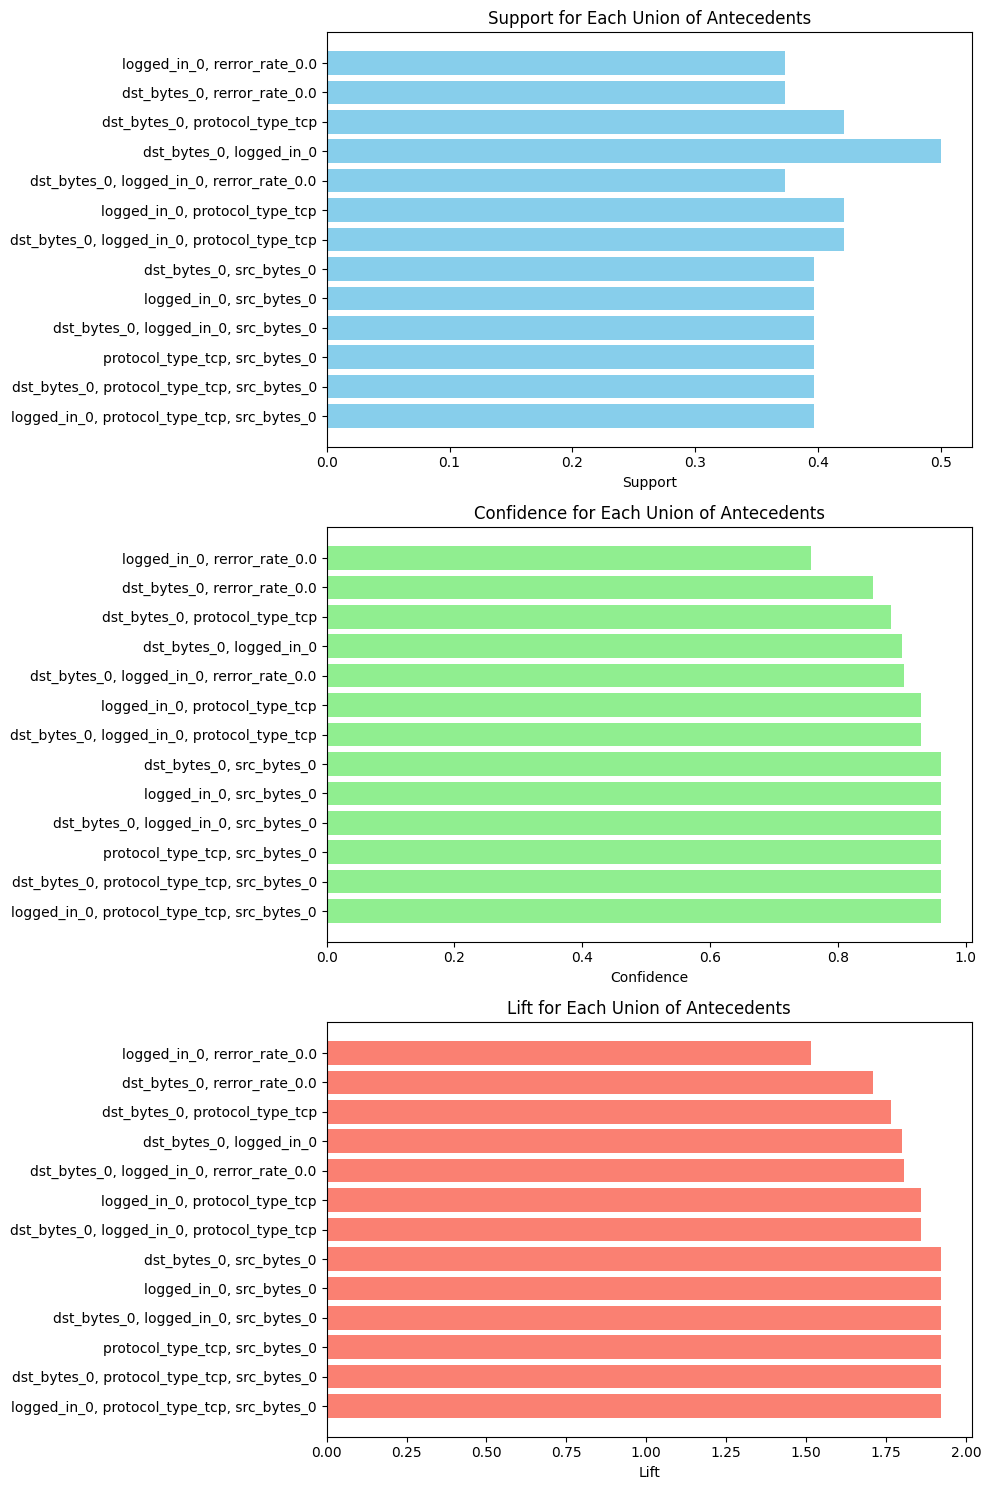

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Aggregate the Linked Rules ---
# Assume that linked_rule_info is the list produced in the code,
# where each element is a tuple (union_a, rules_df).

# Build a list of dictionaries with one row per unique union.
# (If a union appears several times, here we simply take the first occurrence.)
data = []
unique_unions = set()

for union_a, rules_df in linked_rule_info:
    # Use frozenset directly as key; convert to sorted string for display.
    if union_a not in unique_unions:
        unique_unions.add(union_a)
        # Take the first row (all rows have the same consequent and very similar metrics)
        metric = rules_df.iloc[0]
        union_str = ', '.join(sorted(union_a))
        data.append({
            'union': union_str,
            'antecedent_support': metric['antecedent support'],
            'consequent_support': metric['consequent support'],
            'support': metric['support'],
            'confidence': metric['confidence'],
            'lift': metric['lift']
        })

# Create a DataFrame from the aggregated data.
df_linked = pd.DataFrame(data)

# Optionally, sort the DataFrame by a key metric (e.g., confidence) for easier visualization.
df_linked.sort_values('confidence', ascending=False, inplace=True)
print(df_linked)

# --- Visualization ---
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharey=True)

# Support Bar Chart
axs[0].barh(df_linked['union'], df_linked['support'], color='skyblue')
axs[0].set_xlabel('Support')
axs[0].set_title('Support for Each Union of Antecedents')

# Confidence Bar Chart
axs[1].barh(df_linked['union'], df_linked['confidence'], color='lightgreen')
axs[1].set_xlabel('Confidence')
axs[1].set_title('Confidence for Each Union of Antecedents')

# Lift Bar Chart
axs[2].barh(df_linked['union'], df_linked['lift'], color='salmon')
axs[2].set_xlabel('Lift')
axs[2].set_title('Lift for Each Union of Antecedents')

plt.tight_layout()
plt.show()


The summary table shows several different combinations (“unions”) of antecedents that are linked with the anomaly class (with a consequent support of 0.5, meaning that “class_anomaly” appears in 50% of the data).

Antecedent Support (≈0.41–0.56):
Each union (i.e., a set of features such as “logged_in_0, protocol_type_tcp, src_bytes_0”) appears in roughly 41%–56% of the records. This means that these specific combinations are fairly common in the dataset.

Consequent Support (0.5 for all):
The anomaly class appears in 50% of the cases overall. Because the consequent support is high, the anomaly is a frequent event in this context.

Rule Support (≈0.37–0.50):
The support for the rule (i.e., the fraction of records where both the union and the anomaly are present) ranges from about 37% to 50%. In other words, when these antecedents are present, the anomaly occurs in roughly 37%–50% of the records.

Confidence (≈0.76–0.96):
Confidence is very high (mostly above 0.90 for many unions). This indicates that when the antecedent combination is present, the anomaly occurs in 76%–96% of those cases. In other words, these rules are highly reliable predictors of the anomaly.

Lift (≈1.52–1.92):
The lift values indicate that the presence of these antecedents increases the likelihood of observing the anomaly by roughly 52% to 92% compared to the baseline (which is 50% in this dataset). Although the lift isn’t extremely high (compared, for instance, to some single-antecendent lift values), it is notable given the already high base rate of the anomaly.

In summary, the results show that specific combinations of features (such as "logged_in_0, protocol_type_tcp, src_bytes_0" and similar unions) are reliable indicators of an anomaly. When these feature combinations occur, the likelihood of an anomaly is very high (high confidence), and the probability of an anomaly is increased by roughly 50%–90% compared to the baseline (moderate lift).